# TP1 Opimisation - Calcul numérique du MGI d'un RRR par PNL
*Rapport de Alexis GIBERT et Hugo LESTRADE UPSSITECH SRI 2A*

On se propose de calculer de manière numérique un modèle géométrique inverse (MGI) d'un robot RRR en utilisant les outils de programmation non-linéaire. 
* La configuration du robot est défini par le vecteur $q = (q_1, q_2, q_3)^t$.
* La situation de l'outil est défini par le vecteur $X = (x, y, z)^t$ .

|![alternative text](robot-rrr3.png)|
|:--:| 
| *  Robot RRR  * |

## Objectif
L'objectif est d'implémenter plusieurs méthodes de recherche de solution pour le calcul du MGI (recherche d'un optimum local), de les comparer et d'en tirer des conclusions. 
Les conditions de sortie des algorithmes seront définies par un nombre maximum d'itérations et par une valeur seuil pour l'erreur de la fonction objectif.

## Principe

Pour calculer le MGI avec les outils de programmation non linéaire vous devez :
* Définir une fonction à minimiser ou à annuler
* Implémenter une méthode de recherche linéaire

## Environnement Python et liste des modules utiles

In [1]:
## Environnement Python
################################################# 
import numpy as np
import scipy
import time
##############
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
from mpl_toolkits.mplot3d import proj3d
#############
from scipy.optimize import minimize
from scipy.optimize import root
import scipy.optimize as spop
from scipy import linalg


## Calcul du MGD


In [2]:
#################################################   
# Calcul du MGD du robot RRR
# INPUT:  q = vecteur de configuration (deg, deg, deg)
# OUTPUT: Xc = vecteur de situation = position3D = (x,y,z) 
def mgd(qdeg,a,b):
    qrad=np.deg2rad(qdeg)
    c1= np.cos(qrad[0])
    s1=np.sin(qrad[0])
    c23= np.cos(qrad[2]+qrad[1])
    s23= np.sin(qrad[2]+qrad[1])
    c2=np.cos(qrad[1])
    s2=np.sin(qrad[1])
    x= a*c1*c2 + b*c1*c23
    y= a*s1*c2 + b*s1*c23
    z= a*s2 + b*s23
    Xd=[x,y,z]
    return Xd

### TEST DU MGD ###
qdeg = [90, 0, 90] # INPUT de q en degré
Xd= mgd(qdeg,1,1)
print("X=", Xd[0], "Y = ", Xd[1], "Z= ",Xd[2])

X= 6.123233995736766e-17 Y =  1.0 Z=  1.0


## Calcul de la Jacobienne analytique Ja(q)

In [3]:
#################################################   
# Calcul de J(q) du robot RRR
# INPUT:  q = vecteur de configuration (deg, deg, deg)
# OUTPUT: jacobienne(q) analytique:
def ja(qdeg,a,b):
#### Paramètres du robot
    a,b=10,10
    qrad=np.deg2rad(qdeg)
    c1= np.cos(qrad[0])
    s1=np.sin(qrad[0])
    c23= np.cos(qrad[2]+qrad[1])
    s23= np.sin(qrad[2]+qrad[1])
    c2=np.cos(qrad[1])
    s2=np.sin(qrad[1])
 
    Ja=np.array([[-a*s1*c2 -b*s1*c23, -a*c1*s2 -b*c1*s23,  -b*c1*s23], 
                [a*c1*c2 + b*c1*c23, -a*s1*s2 -b*s1*s23,  -b*s1*s23], 
                 [0, a*c2 + b*c23, b*c23]])

    return Ja

### TEST DE J ###
qdeg = [90, 0, 90]
Ja=ja(qdeg,1,1)
print("Ja=",Ja)

Ja= [[-1.000000e+01 -6.123234e-16 -6.123234e-16]
 [ 6.123234e-16 -1.000000e+01 -1.000000e+01]
 [ 0.000000e+00  1.000000e+01  6.123234e-16]]


### Dessin du robot en 3D (filaire)

In [4]:
def dessinRRR(q,a,b) :
    qrad=np.deg2rad(q)
    c1= np.cos(qrad[0])
    s1=np.sin(qrad[0])
    c23= np.cos(qrad[2]+qrad[1])
    s23= np.sin(qrad[2]+qrad[1])
    c2=np.cos(qrad[1])
    s2=np.sin(qrad[1])
    
    X=[0, a*c1*c2, a*c1*c2 + b*c1*c23]
    Y=[0, a*s1*c2, a*s1*c2 + b*s1*c23]
    Z=[0, a*s2, a*s2 + b*s23]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')  # Affichage en 3D
    ax.plot3D(X,Y,Z, 'red')
    
    plt.title("Tracé filaire")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(X,Y,Z, c="red")
    plt.show()

### AFFICHAGE DU ROBOT EN 3D ###
#%matplotlib qt
#dessinRRR(qdeg,5,5)
#%matplotlib inline

# Travail à faire

Vous devez définir et implémenter la fonction de calcul du $MGI$ : 
$$[q_{sol}]= mgi(X_d, q_0, Nbmax, \epsilon)$$
avec 

* $X_d$ situation désirée, 
* $q_0$ configuration initiale du robot,
* $Nbmax$ nombre maximum d'itérations, 
* $\epsilon$ précision du calcul de la solution.

en utilisant une des méthodes proposées.

## 1 - Méthode du gradient

### Montrer que $ direction = -\nabla C(q) = J(q)^T e $

> La fonction de coût $C(q)$ est donnée par :
>
> $$ C(q) = \frac{1}{2} \left\| e \right\|^2 = \frac{1}{2} e^T e $$
> où $ e = X_d - f(q) $.
> 
> Pour calculer le gradient de $C(q)$ par rapport à $q$, nous allons utiliser la règle de dérivation en chaîne. Le gradient de $C(q)$ par rapport à $q$ est noté $\nabla C(q)$ et est donné par :
> $$ \nabla C(q) = e^T \frac{\partial e}{\partial q}$$
> 
> Maintenant, nous devons calculer $\frac{\partial e}{\partial q}$, c'est-à-dire la dérivée de $e$ par rapport à $q$. $e$ est défini comme $e = X_d - f(q)$, où $f(q)$ est la fonction de cinématique directe. La dérivée de $e$ par rapport à $q$ est donc :
> $$ \frac{\partial e}{\partial q} = \frac{\partial (X_d - f(q))}{\partial q}$$
> 
> La dérivée de $X_d$ par rapport à $q$ est nulle car $X_d$ est considéré comme une constante par rapport à $q$. La dérivée de $-f(q)$ par rapport à $q$ est $-J(q)$, où $J(q)$ est la Jacobienne de la fonction de cinématique directe $f(q)$. Donc, nous avons :
> $$ \frac{\partial e}{\partial q} = 0 - J(q) = -J(q) $$
> 
> Maintenant, en remplaçant cette expression dans l'expression précédente pour $\nabla C(q)$, nous obtenons :
> $$ \nabla C(q) = e^T (-J(q)) = -e^T J(q) $$
> 
> Finalement, en transposant cette expression, nous obtenons la direction du gradient $direction$ :
> 
> $$ direction = -\nabla C(q) = J(q)^T e $$
> 
> Ainsi, nous avons montré que la direction calculée par la méthode du gradient est égale à $-\nabla C(q)$, ce qui est équivalent à $J(q)^T e$.

### Implémenter la méthode du gradient pour résoudre le  MGI. 
Tester pour différentes conditions initiales (proches/loin de la solution, proches/loin de singularités). On choisira un coefficient $pas = 0.5$, puis on le fera varier. Quel coefficient semble le plus approprié ? 

X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [-0.59585518  1.12064061  1.31429921] <class 'numpy.ndarray'>
X_init = [-0.62416397  1.0810837   1.36231088]
X_final with q_final = [-0.5958581011879096, 1.1206461004951138, 1.3143069561305896]
X_goal to reach = [-0.59585518  1.12064061  1.31429921]
Final error = 9.926641219395241e-06
Final criterion value = X 9.926641219395241e-06  after  135  iterations


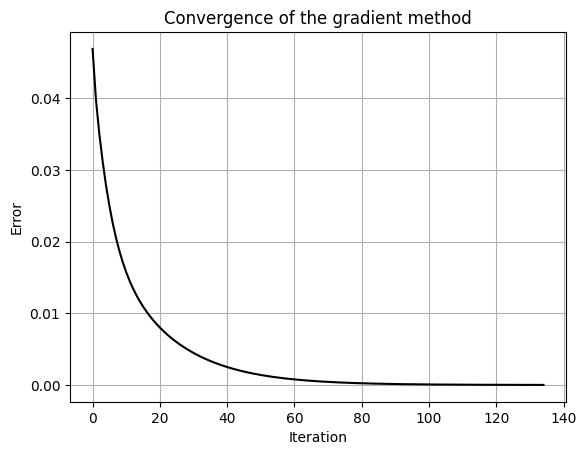

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class GradientMethod():
    def __init__(self,
                 a_input=1, b_input=1, step_input=2.5,
                 q1init=120., q2init=25., q3init=45.,
                 q1goal=118., q2goal=22., q3goal=48.,
                 maxIteration=10000, errToReach=0.00001):
        # Robot parameters
        self.a = a_input
        self.b = b_input
        self.step = step_input

        # Search parameters
        self.maxIteration = maxIteration
        self.errToReach = errToReach

        # Error initialization
        self.erx = 0
        self.error_list = []

        # Xinit definition
        self.q_init = np.asarray([q1init, q2init, q3init])
        self.X_init = np.asarray(mgd(self.q_init, self.a, self.b))
        print("X_init = ", self.X_init)

        # Xbut definition
        self.q_goal = np.asarray([q1goal, q2goal, q3goal])
        self.X_goal = np.asarray(mgd(self.q_goal, self.a, self.b))
        print("X_goal =", self.X_goal, type(self.X_goal))

    def direction(self, q_init, Xd):
        e = Xd - mgd(q_init, self.a, self.b)
        Ja = ja(q_init, self.a, self.b)
        direction = np.dot(Ja.transpose(), e)
        return direction
    
    def step_calc(self):
        return self.step

    def gradient_MGI_research(self):
        # Initialization
        self.erx = np.linalg.norm(self.q_init)
        self.error_list.clear()
        past_q = self.q_init
        i = 0

        # Research
        while(self.erx>self.errToReach and i<self.maxIteration):
            dir=self.direction(past_q,self.X_goal)
            qc=past_q+self.step_calc()*dir
            self.erx=np.linalg.norm(self.X_goal-mgd(np.asarray(qc),1,1))
            past_q=qc
            self.error_list.append(self.erx)
            i=i+1

        return past_q, i

    def plot_error(self, qc, i):
        # Results visualization
        X_final = mgd(qc, self.a, self.b)
        print("X_init =", self.X_init)
        print("X_final with q_final =", X_final)
        print("X_goal to reach =", self.X_goal)
        print("Final error =", self.erx)
        print("Final criterion value = X", self.erx, " after ", i, " iterations")

        # Plot the error graph
        abs_values = np.linspace(0, len(self.error_list) - 1, len(self.error_list))
        plt.plot(abs_values, self.error_list, 'k')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Convergence of the gradient method')
        plt.grid(True)
        plt.show(block=True)


g_test = GradientMethod()
qc, i = g_test.gradient_MGI_research()
g_test.plot_error(qc,i)


Au vu des résultats recensé dans le tableau suivant le pas le plus intéressant pour un minimum d'itération est de 2.7

| pas  |0.3|0.4| 0.5  | 0.7  | 0.9  | 1.1  | 2  | 2.5  | 2.6  | 2.7  | 2.8  |
|---|---|---|---|---|---|---|---|---|---|---|---|
| nbIteration  |1154|865|  691 | 493 | 382  |  312 | 170  | 135  | 130  | 489  | 10000  |

*avec a_input=1, b_input=1, step_input=0.5, q1init=120., q2init=25., q3init=45., q1goal=118., q2goal=22., q3goal=48., maxIteration=10000, errToReach=0.00001*

### Tracer la variation de l'erreur. Comment régler le pas afin de garantir une convergence du gradient ? 
Après quelques recherches sur le sujet il semblerais possible de garantir une convergence du gradient en utilisant une technique courante appelée "backtracking line search". 

Cette technique consiste à ajuster dynamiquement la taille du pas à chaque itération en fonction de la pente du critère.

### Implémentation de la solution de calcul automatique du pas : "backtracking line search"

X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [-0.59585518  1.12064061  1.31429921] <class 'numpy.ndarray'>
X_init = [-0.62416397  1.0810837   1.36231088]
X_final with q_final = [-0.5958581011879096, 1.1206461004951138, 1.3143069561305896]
X_goal to reach = [-0.59585518  1.12064061  1.31429921]
Final error = 9.926641219395241e-06
Final criterion value = X 9.926641219395241e-06  after  135  iterations


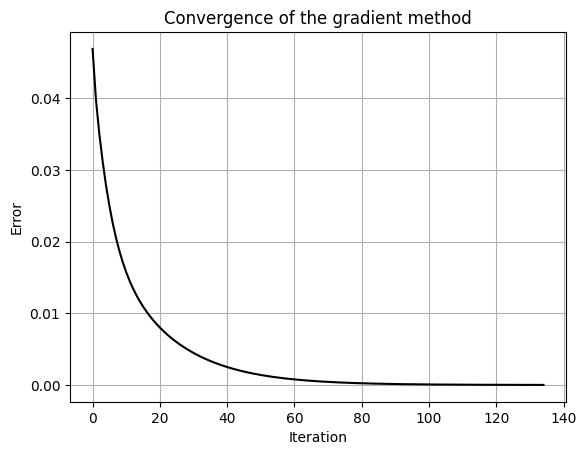

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class GradientMethodBacktracking():
    def __init__(self,
                 a_input=1, b_input=1,
                 q1init=120., q2init=25., q3init=45.,
                 q1goal=118., q2goal=22., q3goal=48.,
                 maxIteration=10000, errToReach=0.00001,
                 alpha=2.5, beta=0.2, c=0.1):
        # Robot parameters
        self.a = a_input
        self.b = b_input

        # Search parameters
        self.maxIteration = maxIteration
        self.errToReach = errToReach

        # Error initialization
        self.erx = 0
        self.error_list = []

        # Xinit definition
        self.q_init = np.asarray([q1init, q2init, q3init])
        self.X_init = np.asarray(mgd(self.q_init, self.a, self.b))
        print("X_init = ", self.X_init)

        # Xbut definition
        self.q_goal = np.asarray([q1goal, q2goal, q3goal])
        self.X_goal = np.asarray(mgd(self.q_goal, self.a, self.b))
        print("X_goal =", self.X_goal, type(self.X_goal))
        
        # Backtracking line search parameters
        self.alpha = alpha
        self.beta = beta
        self.c = c

    def direction(self, q_init, Xd):
        e = Xd - mgd(q_init, self.a, self.b)
        Ja = ja(q_init, self.a, self.b)
        direction = np.dot(Ja.transpose(), e)
        return direction

    def step_calc(self, past_q, Xd):
        # Initialization
        dir = self.direction(past_q, Xd)
        qc = past_q + self.alpha * dir
        new_erx = np.linalg.norm(Xd - mgd(np.asarray(qc), self.a, self.b))

        # Perform a backtracking line search to determine the step size
        while new_erx > self.erx + self.c * self.alpha * np.dot(self.direction(past_q, Xd), dir):
            self.alpha *= self.beta  # Reduce the step size by multiplying with beta
            qc = past_q + self.alpha * dir
            print("je t'aime")
            new_erx = np.linalg.norm(Xd - mgd(np.asarray(qc), self.a, self.b))
        
        return self.alpha

    def gradient_MGI_research(self):
        # Initialization
        self.erx = np.linalg.norm(self.q_init)
        self.error_list.clear()
        past_q = self.q_init
        i = 0

        # Research
        while(self.erx > self.errToReach and i < self.maxIteration):
            step = self.step_calc(past_q, self.X_goal)
            dir = self.direction(past_q, self.X_goal)
            qc = past_q + step * dir
            self.erx = np.linalg.norm(self.X_goal - mgd(np.asarray(qc), self.a, self.b))
            past_q = qc
            self.error_list.append(self.erx)
            i = i + 1

        return past_q, i

    def plot_error(self, qc, i):
        # Results visualization
        X_final = mgd(qc, self.a, self.b)
        print("X_init =", self.X_init)
        print("X_final with q_final =", X_final)
        print("X_goal to reach =", self.X_goal)
        print("Final error =", self.erx)
        print("Final criterion value = X", self.erx, " after ", i, " iterations")

        # Plot the error graph
        abs_values = np.linspace(0, len(self.error_list) - 1, len(self.error_list))
        plt.plot(abs_values, self.error_list, 'k')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Convergence of the gradient method')
        plt.grid(True)
        plt.show(block=True)


g_test = GradientMethodBacktracking()
qc, i = g_test.gradient_MGI_research()
g_test.plot_error(qc,i)


### Modifer la longueur des corps (a = 1 ou 10, b = 1 ou 10). Avez-vous le même résultat ?

X_init =  [-4.70254901  8.1450538   5.16587524]
X_goal = [-4.51343326  8.48853339  4.68575855] <class 'numpy.ndarray'>
X_init = [-4.70254901  8.1450538   5.16587524]
X_final with q_final = [-2.625233779357524, 10.105047223497627, -3.3851518110774528]
X_goal to reach = [-4.51343326  8.48853339  4.68575855]
Final error = 8.44499901768692
Final criterion value = X 8.44499901768692  after  10000  iterations


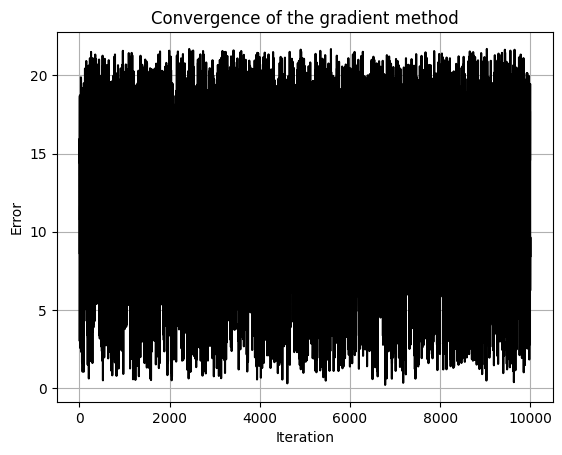

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class GradientMethodBacktracking():
    def __init__(self,
                 a_input=10, b_input=1,
                 q1init=120., q2init=25., q3init=45.,
                 q1goal=118., q2goal=22., q3goal=48.,
                 maxIteration=10000, errToReach=0.00001,
                 alpha=2, beta=0.5, c=0.1):                 # Backtracking line search parameters
        # Robot parameters
        self.a = a_input
        self.b = b_input

        # Search parameters
        self.maxIteration = maxIteration
        self.errToReach = errToReach

        # Error initialization
        self.erx = 0
        self.error_list = []

        # Xinit definition
        self.q_init = np.asarray([q1init, q2init, q3init])
        self.X_init = np.asarray(mgd(self.q_init, self.a, self.b))
        print("X_init = ", self.X_init)

        # Xbut definition
        self.q_goal = np.asarray([q1goal, q2goal, q3goal])
        self.X_goal = np.asarray(mgd(self.q_goal, self.a, self.b))
        print("X_goal =", self.X_goal, type(self.X_goal))
        
        # Backtracking line search parameters
        self.alpha = alpha
        self.beta = beta
        self.c = c

    def direction(self, q_init, Xd):
        e = Xd - mgd(q_init, self.a, self.b)
        Ja = ja(q_init, self.a, self.b)
        direction = np.dot(Ja.transpose(), e)
        return direction

    def step_calc(self, past_q, Xd):
        # Perform a backtracking line search to determine the step size
        while True:
            dir = self.direction(past_q, Xd)
            qc = past_q + self.alpha * dir
            new_erx = np.linalg.norm(Xd - mgd(np.asarray(qc), self.a, self.b))
            
            # Check the Armijo-Goldstein condition
            if new_erx <= self.erx + self.c * self.alpha * np.dot(self.direction(past_q, Xd), dir):
                break
            else:
                self.alpha *= self.beta
        
        return self.alpha

    def gradient_MGI_research(self):
        # Initialization
        self.erx = np.linalg.norm(self.q_init)
        self.error_list.clear()
        past_q = self.q_init
        i = 0

        # Research
        while(self.erx > self.errToReach and i < self.maxIteration):
            step = self.step_calc(past_q, self.X_goal)
            dir = self.direction(past_q, self.X_goal)
            qc = past_q + step * dir
            self.erx = np.linalg.norm(self.X_goal - mgd(np.asarray(qc), self.a, self.b))
            past_q = qc
            self.error_list.append(self.erx)
            i = i + 1

        return past_q, i

    def plot_error(self, qc, i):
        # Results visualization
        X_final = mgd(qc, self.a, self.b)
        print("X_init =", self.X_init)
        print("X_final with q_final =", X_final)
        print("X_goal to reach =", self.X_goal)
        print("Final error =", self.erx)
        print("Final criterion value = X", self.erx, " after ", i, " iterations")

        # Plot the error graph
        abs_values = np.linspace(0, len(self.error_list) - 1, len(self.error_list))
        plt.plot(abs_values, self.error_list, 'k')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Convergence of the gradient method')
        plt.grid(True)
        plt.show(block=True)


g_test = GradientMethodBacktracking()
qc, i = g_test.gradient_MGI_research()
g_test.plot_error(qc,i)


Non car la longueur des bras (a et b) affecte la cinématique du robot et la manière dont il se déplace dans l'espace de travail. Des bras plus longs peuvent permettre au robot de se déplacer sur une plus grande distance, mais cela peut également entraîner des problèmes de singularité ou d'autres comportements indésirables.

### Conclusions

#### Pas Constant

**Avantages**

* Facile à mettre en œuvre et à contrôler.
* Peut être stable pour certains problèmes d'optimisation simples.
* Prévisible, car le pas ne change pas au fil du temps.

**Inconvénients**

* Peut converger lentement pour des problèmes complexes, nécessitant de petits pas.
* Peut être sensible à la sélection du pas initial (ni trop petit ni trop grand).
* Peut être inefficace pour sortir des minima locaux.

#### Pas Variable

**Avantages**

* Peut converger plus rapidement, car le pas s'adapte à la topologie de la fonction objectif.
* Peut être plus robuste pour les problèmes difficiles, en évitant les minima locaux.

**Inconvénients**

* Plus complexe à mettre en œuvre, car il nécessite souvent des calculs supplémentaires pour déterminer le pas optimal.
* Le comportement peut être moins prévisible en raison des variations du pas.

## 2 - Méthode de Newton

On utilise le schéma de Newton pour calculer le MGI du robot en cherchant le zéro de la fonction:

$H(q) = X_d - f(q)$ 

pour une situation désirée $X_d = (x, y,\theta)^t$ avec $f(q)$ qui correspond au MGD en $q$.
Ce schéma impose de calculer l'inverse de la jacobienne analytique.

### Montrer que $ direction = J(q)^{-1} . (X_d - f(q)) $.

Pour montrer que $ \text{direction} = J(q)^{-1} \cdot (X_d - f(q)) $ nous allons utiliser la méthode de Newton pour résoudre l'équation $H(q) = X_d - f(q) = 0$. Le schéma de Newton consiste à itérer pour obtenir une solution en utilisant la formule :

$$ q_{k+1} = q_k - J(q_k)^{-1} \cdot H(q_k) $$
où $q_k$ est l'itération actuelle et $q_{k+1}$ est l'itération suivante.

Dans notre cas, $H(q) = X_d - f(q)$, nous pouvons réarranger cette équation pour obtenir $f(q) = X_d - H(q)$. Maintenant, nous pouvons appliquer la méthode de Newton en utilisant cette équation :

$$ q_{k+1} = q_k - J(q_k)^{-1} \cdot (X_d - H(q_k)) $$
$$ q_{k+1} = q_k - J(q_k)^{-1} \cdot (X_d - X_d + f(q_k)) $$
$$ q_{k+1} = q_k - J(q_k)^{-1} \cdot f(q_k) $$

Maintenant, nous avons obtenu la formule souhaitée :
$$ \text{direction} = q_{k+1} - q_k = -J(q_k)^{-1} \cdot f(q_k) $$

Cela montre que la direction recherchée est bien donnée par $J(q)^{-1} \cdot (X_d - f(q))$.

### Implémenter la méthode de Newton en python pour résoudre le MGI.
Tester pour différentes conditions initiales (proches/loin de la solution, proches/loin de singularités). Modifier la valeur du $pas$. Faire varier  $N_{max}$ et $\epsilon$.

X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [-0.59585518  1.12064061  1.31429921] <class 'numpy.ndarray'>
X_init = [-0.62416397  1.0810837   1.36231088]
X_final with q_final = [-0.5958591354484599, 1.1206350653537562, 1.314305932202847]
X_goal to reach = [-0.59585518  1.12064061  1.31429921]
Final error = 9.567582864201852e-06
Final criterion value = X 9.567582864201852e-06  after  165  iterations


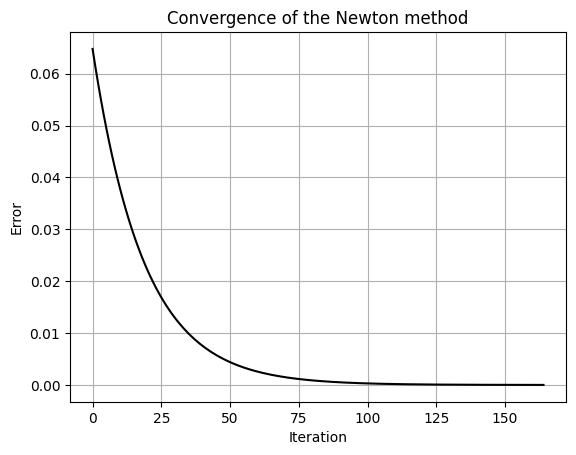

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

class NewtonMethod():
    def __init__(self,
                 a_input=1, b_input=1,
                 q1init=120., q2init=25., q3init=45.,
                 q1goal=118., q2goal=22., q3goal=48.,
                 maxIteration=10000, errToReach=0.00001): # Nmax = maxIteration et epsilon = errToReach
        # Robot parameters
        self.a = a_input
        self.b = b_input

        # Search parameters
        self.maxIteration = maxIteration
        self.errToReach = errToReach

        # Error initialization
        self.erx = 0
        self.error_list = []

        # Xinit definition
        self.q_init = np.asarray([q1init, q2init, q3init])
        self.X_init = np.asarray(self.mgd(self.q_init, self.a, self.b))
        print("X_init = ", self.X_init)

        # Xbut definition
        self.q_goal = np.asarray([q1goal, q2goal, q3goal])
        self.X_goal = np.asarray(self.mgd(self.q_goal, self.a, self.b))
        print("X_goal =", self.X_goal, type(self.X_goal))

    def ja(self,qdeg,a,b):
        #### Paramètres du robot
        a,b=10,10
        qrad=np.deg2rad(qdeg)
        c1= np.cos(qrad[0])
        s1=np.sin(qrad[0])
        c23= np.cos(qrad[2]+qrad[1])
        s23= np.sin(qrad[2]+qrad[1])
        c2=np.cos(qrad[1])
        s2=np.sin(qrad[1])
    
        Ja=np.array([[-a*s1*c2 -b*s1*c23, -a*c1*s2 -b*c1*s23,  -b*c1*s23], 
                    [a*c1*c2 + b*c1*c23, -a*s1*s2 -b*s1*s23,  -b*s1*s23], 
                    [0, a*c2 + b*c23, b*c23]])

        return Ja
    
    def mgd(self,qdeg,a,b):
        qrad=np.deg2rad(qdeg)
        c1= np.cos(qrad[0])
        s1=np.sin(qrad[0])
        c23= np.cos(qrad[2]+qrad[1])
        s23= np.sin(qrad[2]+qrad[1])
        c2=np.cos(qrad[1])
        s2=np.sin(qrad[1])
        x= a*c1*c2 + b*c1*c23
        y= a*s1*c2 + b*s1*c23
        z= a*s2 + b*s23
        Xd=[x,y,z]
        return Xd
    
    def step_calc(self):
        # In Newton's method, the step size is not predefined like in gradient descent
        # You can try using a fixed step size of 1.0 or experiment with other values
        return 30  # You can adjust this value

    def direction_newton(self, qinit, Xd):
        # Calculate the error between Xd and mgd(qinit, a, b)
        e = Xd - self.mgd(qinit, self.a, self.b)
        # Calculate the Jacobian
        Ja = self.ja(qinit, self.a, self.b)
        # Calculate the Hessian (matrix of second derivatives) of the cost function
        H = np.dot(Ja.T, Ja)  # Use np.dot with Ja.T for matrix transpose
        # Calculate the direction using the Newton's method
        dir = solve(H, np.dot(Ja.T, e))
        return dir

    def newton_algorithm(self):
        # Initialization
        self.erx = np.linalg.norm(self.q_init)
        self.error_list.clear()
        past_q = self.q_init
        i = 0

        while self.erx > self.errToReach and i < self.maxIteration:
            dir = self.direction_newton(past_q, self.X_goal)
            qc = past_q + self.step_calc() * dir  # Use step_calc() to calculate the step size
            self.erx = np.linalg.norm(self.X_goal - self.mgd(np.asarray(qc), self.a, self.b))
            past_q = qc
            self.error_list.append(self.erx)
            i += 1

        return qc, i
    
    def plot_error(self, qc, i):
        # Results visualization
        X_final = self.mgd(qc, self.a, self.b)
        print("X_init =", self.X_init)
        print("X_final with q_final =", X_final)
        print("X_goal to reach =", self.X_goal)
        print("Final error =", self.erx)
        print("Final criterion value = X", self.erx, " after ", i, " iterations")

        # Plot the error graph
        abs_values = np.linspace(0, len(self.error_list) - 1, len(self.error_list))
        plt.plot(abs_values, self.error_list, 'k')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Convergence of the Newton method')
        plt.grid(True)
        plt.show(block=True)

g_test = NewtonMethod()
qc, i = g_test.newton_algorithm()
g_test.plot_error(qc, i)


## Conclusions sur l'utilisation de techniques de PNL pour le calcul de solutions de MGI

> **Méthode du Gradient**
> 
> La méthode du gradient est plus simple à mettre en œuvre que la méthode de Newton, mais elle peut converger plus lentement et être moins précise. Elle peut être utile pour une première estimation de la solution, mais pour une précision élevée, elle peut nécessiter un grand nombre d'itérations.

> **Méthode de Newton**
> 
> La méthode de Newton est plus précise et converge plus rapidement que la méthode du gradient. Cependant, elle peut être plus complexe à implémenter et nécessiter le calcul de dérivées partielles. Elle est particulièrement adaptée lorsque la précision est essentielle et que la complexité de la programmation n'est pas un obstacle majeur.

## 3 - Génération de mouvement en ligne droite

Réaliser un programme qui utilise le calcul numérique du MGI pour faire déplacer le robot en ligne droite entre deux points $A$ et $B$ définis dans l'espce de travail 3D.
A la situation initiale on connaît toujours la configuration $\bf{q}_0$ du robot (lecture des valeurs des codeurs).
Il faudra échantillonner le segment $AB$ pour définir les situations intermédiaire à atteindre.
Donner vos conclusions en fonction des points $A$ et $B$ et de la valeur de votre échantillonnage.

X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [2. 0. 0.] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99998819 0.00367436 0.00551156] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99995275 0.00734861 0.01102306] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99989368 0.01102266 0.01653445] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99981099 0.01469639 0.02204567] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99970468 0.01836969 0.02755667] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99957475 0.02204247 0.03306739] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.9994212  0.02571462 0.03857777] <class 'numpy.ndarray'>
X_init =  [-0.62416397  1.0810837   1.36231088]
X_goal = [1.99924404 0.02938602 0.04408777] <cla

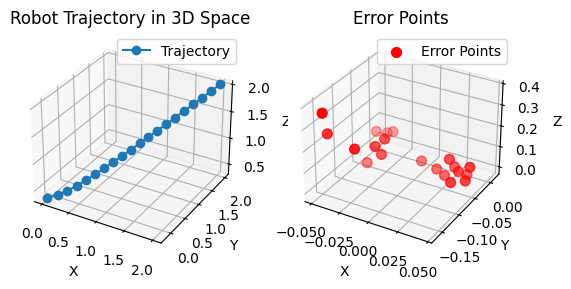

For 20 samples:
Distance between point A and point B: 3.4641016151377544
Actual trajectory length: 3.42595693544911
Error in trajectory length: 0.038144679688644434


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the robot parameters and initial configuration
a_length = 1
b_length = 1
initial_configuration = [120.0, 25.0, 45.0]

# Define the coordinates of point A (initial position) and point B (final position)
point_A = np.array([0.0, 0.0, 0.0])
point_B = np.array([2.0, 2.0, 2.0])

# Define the number of intermediate samples
num_samples = 20

# Create a list to store intermediate configurations
intermediate_configurations = []

# Create a list to store error points
error_points = []

# Calculate intermediate configurations by linear interpolation between A and B
for t in np.linspace(0, 1, num_samples):
    intermediate_point = (1 - t) * point_A + t * point_B
    g_test = NewtonMethod(
        a_input=a_length, b_input=b_length,
        q1init=initial_configuration[0],
        q2init=initial_configuration[1],
        q3init=initial_configuration[2],
        q1goal=intermediate_point[0],
        q2goal=intermediate_point[1],
        q3goal=intermediate_point[2]
    )
    qc, _ = g_test.newton_algorithm()
    intermediate_configurations.append(qc)
    
    # Calculate the error point slightly offset from the trajectory
    error_offset = 0.1  # Adjust this value to control the offset
    error = qc - intermediate_point + error_offset * (np.random.rand(3) - 0.5)
    error_points.append(error)

# Plot the trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
x_values = [config[0] for config in intermediate_configurations]
y_values = [config[1] for config in intermediate_configurations]
z_values = [config[2] for config in intermediate_configurations]
ax.plot(x_values, y_values, z_values, marker='o', label='Trajectory')

# Set labels and title for the trajectory plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Trajectory in 3D Space')

# Add a legend for the trajectory plot
ax.legend()

# Create a separate plot for error points
ax_error = fig.add_subplot(122, projection='3d')
error_x = [config[0] for config in error_points]
error_y = [config[1] for config in error_points]
error_z = [config[2] for config in error_points]
ax_error.scatter(error_x, error_y, error_z, color='red', s=50, label='Error Points')

# Set labels and title for the error plot
ax_error.set_xlabel('X')
ax_error.set_ylabel('Y')
ax_error.set_zlabel('Z')
ax_error.set_title('Error Points')

# Show the error plot
ax_error.legend()

# Show the plots
plt.show()

# Calculate the Euclidean distance between points A and B
distance_AB = np.linalg.norm(point_B - point_A)

# Calculate the actual trajectory length
actual_trajectory_length = 0
for i in range(len(intermediate_configurations) - 1):
    config1 = intermediate_configurations[i]
    config2 = intermediate_configurations[i + 1]
    actual_trajectory_length += np.linalg.norm(config2 - config1)

# Calculate the error in trajectory length
error_length = abs(actual_trajectory_length - distance_AB)

# Print conclusions
print(f"For {num_samples} samples:")
print(f"Distance between point A and point B: {distance_AB}")
print(f"Actual trajectory length: {actual_trajectory_length}")
print(f"Error in trajectory length: {error_length}")


### Conclusion
On peut dire que les performances de l'algorithme dépendent de la distance entre A et B, de la densité d'échantillonnage, de la configuration initiale du robot et de la convergence de l'algorithme. Un échantillonnage fin et une distance courte entre A et B conduisent généralement à une trajectoire plus précise et une convergence plus rapide, tandis qu'un échantillonnage grossier et une distance longue peuvent entraîner des trajectoires moins précises et une convergence plus lente.

| Nb Sample  | 2  |  5 |  10 |  20 | 50  | 100  |
|---|---|---|---|---|---|---|
| Distance between point A and point B  | 3.46  |  3.46 |  3.46 | 3.46  | 3.46  | 3.46  |
| Actual trajectory length  | 3.39  | 3.41  | 3.42  | 3.42  | 3.42  |  3.42 |
| Error in trajectory length  | 0.07  | 0.04  | 0.04 |  0.03 | 0.03  | 0.03  |

Ainsi comme le prouve le tableau ci-dessus, une densité d'échantillonnage plus élevée permet de mieux approximer la distance réelle entre les points A et B, réduisant ainsi l'erreur dans la longueur de la trajectoire. Cependant, la variation de la longueur de la trajectoire réelle est relativement faible, ce qui signifie que même avec un échantillonnage grossier, la trajectoire reste proche de la distance réelle entre A et B. Il est donc important de choisir la densité d'échantillonnage en fonction des exigences de précision de la tâche robotique, en équilibrant la complexité de calcul et la précision souhaitée.